In [139]:
import os
from typing import Union
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import openfoamparser_mai as Ofpp

from scipy.interpolate import griddata

PathLike = Union[str, os.PathLike]

import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!pip3 install deepxde

Defaulting to user installation because normal site-packages is not writeable
  Using cached DeepXDE-1.8.4-py3-none-any.whl (154 kB)
  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)

[notice] A new release of pip available: 22.1.2 -> 23.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [140]:
def max_timestep(simulation: PathLike) -> PathLike:
    timestep = str(max(map(lambda x: int(x) if x.isdigit() else -1, os.listdir(simulation))))
    return os.path.join(simulation, timestep)


def read_mesh_centers(simulation: PathLike):
    timestep = max_timestep(simulation)
    Cx = Ofpp.parse_internal_field(os.path.join(timestep, 'Cx'))
    Cy = Ofpp.parse_internal_field(os.path.join(timestep, 'Cy'))
    Cz = Ofpp.parse_internal_field(os.path.join(timestep, 'Cz'))
    return np.dstack((Cx, Cy, Cz))[0]


def read_speed_vector_field(simulation: PathLike):
    timestep = max_timestep(simulation)
    U = Ofpp.parse_internal_field(os.path.join(timestep, 'U'))
    return U


def read_pressure_field(simulation: PathLike):
    timestep = max_timestep(simulation)
    p = Ofpp.parse_internal_field(os.path.join(timestep, 'p'))
    return p


In [141]:
def resize(a):
    return a[:,:-1]

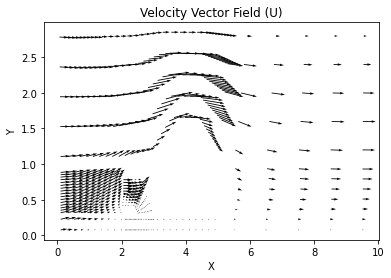

In [232]:

path_to_data_high = './data/hig_dim'
path_to_data_low = './data/low_dim'
simulation_name = 'vel1'
saveOutput = 1


simulation_low = os.path.join(path_to_data_low, simulation_name)
simulation_high = os.path.join(path_to_data_high, simulation_name)

C_low = read_mesh_centers(simulation_low)
U_low = read_speed_vector_field(simulation_low)
p_low = read_pressure_field(simulation_low)

C_high = read_mesh_centers(simulation_high)
U_high= read_speed_vector_field(simulation_high)
p_high = read_pressure_field(simulation_high)

C_low = resize(C_low)
U_low = resize(U_low)

C_high = resize(C_high)
U_high = resize(U_high)

fig, ax = plt.subplots()
ax.quiver(C_low[:, 0], C_low[:, 1], U_low[:, 0], U_low[:, 1])
#ax.quiver(C_low[:, 0], C_low[:, 1], U_low[:, 0], U_low[:, 1])
# Add labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Velocity Vector Field (U)")

# Display the plot
plt.savefig(f"high_field.png")

In [233]:
data_low = np.concatenate((C_low,U_low), axis=1)
data_high = np.concatenate((C_high,U_high), axis=1)
data_low.shape

(575, 4)

In [234]:
data_low = np.concatenate((data_low, p_low.reshape(-1,1)),axis = 1)
data_high = np.concatenate((data_high, p_high.reshape(-1,1)),axis = 1)

In [194]:
data_low.shape

(575, 5)

In [236]:
data_low = torch.Tensor(data_low, device=device)
data_high= torch.Tensor(data_high, device=device)
data_low.shape

torch.Size([575, 5])

In [206]:
data_high.shape

torch.Size([12940, 5])

In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# Define the Anisotropic Diffusion Model
class AnisotropicDiffusion(nn.Module):
    def __init__(self, time_step=0.1, iterations=10):
        super(AnisotropicDiffusion, self).__init__()
        self.time_step = time_step
        self.iterations = iterations
        self.diffusion_kernel = nn.Parameter(torch.randn(2, 1, 3, 3))

    def forward(self, input_data):
        # Convert input_data to a 2D grid
        batch_size = input_data.shape[0]
        input_grid = torch.zeros(batch_size, 2, 64, 64, device=input_data.device)
        coords = input_data[:, :2].long()
        values = input_data[:, 2:]
        for i in range(batch_size):
            input_grid[i, 0].scatter_(1, coords[i, 0].view(-1, 1), values[i, 0].view(-1, 1))
            input_grid[i, 1].scatter_(1, coords[i, 1].view(-1, 1), values[i, 1].view(-1, 1))

        # Convert input_grid to the correct shape
        input_grid = input_grid.transpose(1, 2).transpose(2, 3)
        input_grid = input_grid.reshape(-1, 2, 64, 64)

        # Apply diffusion
        velocity_field = input_grid.clone()
        for _ in range(self.iterations):
            gradient = nn.functional.conv2d(velocity_field[:, 0:1, :, :], self.diffusion_kernel, padding=1)
            diffused = velocity_field + self.time_step * gradient
            velocity_field = diffused

        # Convert velocity_field back to the format of input_data
        velocity_field = velocity_field.view(batch_size, 64, 64, 2).transpose(1, 3).transpose(2, 3)

        # Create a meshgrid for x and y coordinates
        x_coords = torch.arange(0, 64).view(1, 1, 64).expand(batch_size, 64, 64)
        y_coords = torch.arange(0, 64).view(1, 64, 1).expand(batch_size, 64, 64)

        # Concatenate coordinates with velocity components
        velocity_field_with_coords = torch.stack((x_coords, y_coords, velocity_field[:, 0], velocity_field[:, 1]), dim=-1)

        # Reshape to have the format (x, y, v_x, v_y)
        velocity_field_with_coords = velocity_field_with_coords.view(batch_size, -1, 4)

        return velocity_field_with_coords
    
# Instantiate the model
model = AnisotropicDiffusion()

# Define a loss function and an optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, low_res_data, reference_high_res_data, epochs, batch_size):
    num_samples = low_res_data.shape[0]
    num_batches = num_samples // batch_size
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            optimizer.zero_grad()
            high_res_field = model(low_res_data[start_idx:end_idx])
            reference_high_res_field = model(reference_high_res_data[start_idx:end_idx])
            loss = loss_function(high_res_field, reference_high_res_field)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss / num_batches}')

# Train the model
train_model(model, data_low, data_high, epochs=100, batch_size=32)

Epoch: 1/100, Loss: 0.011855264221701552


KeyboardInterrupt: 

In [238]:
low_res_data[0:32].shape

torch.Size([32, 2])

In [231]:
def forward(self, input_data):
    # Convert input_data to a 2D grid
    batch_size = input_data.shape[0]
    input_grid = torch.zeros(batch_size, 2, 64, 64, device=input_data.device)
    coords = input_data[:, :2].long()
    values = input_data[:, 2:]
    for i in range(batch_size):
        input_grid[i, 0].scatter_(1, coords[i, 0].view(-1, 1), values[i, 0].view(-1, 1))
        input_grid[i, 1].scatter_(1, coords[i, 1].view(-1, 1), values[i, 1].view(-1, 1))

    # Convert input_grid to the correct shape
    input_grid = input_grid.transpose(1, 2).transpose(2, 3)
    input_grid = input_grid.reshape(-1, 2, 64, 64)

    # Apply diffusion
    velocity_field = input_grid.clone()
    for _ in range(self.iterations):
        gradient = nn.functional.conv2d(velocity_field[:, 0:1, :, :], self.diffusion_kernel, padding=1)
        diffused = velocity_field + self.time_step * gradient
        velocity_field = diffused

    # Convert velocity_field back to the format of input_data
    velocity_field = velocity_field.view(batch_size, 64, 64, 2).transpose(1, 3).transpose(2, 3)

    # Create a meshgrid for x and y coordinates
    x_coords = torch.arange(0, 64).view(1, 1, 64).expand(batch_size, 64, 64)
    y_coords = torch.arange(0, 64).view(1, 64, 1).expand(batch_size, 64, 64)

    # Concatenate coordinates with velocity components
    velocity_field_with_coords = torch.stack((x_coords, y_coords, velocity_field[:, 0], velocity_field[:, 1]), dim=-1)

    # Reshape to have the format (x, y, v_x, v_y)
    velocity_field_with_coords = velocity_field_with_coords.view(batch_size, -1, 4)

    return velocity_field_with_coords

0.0

In [ ]:
low= []
for i in range(100):
    low.append('./data/low_dim/vel{}'.format(i+1))

high = []
for i in range(100):
    high.append('./data/hig_dim/vel{}'.format(i+1))

In [ ]:
C_high = read_mesh_centers(simulation_high)
U_high= read_speed_vector_field(simulation_high)
p_high = read_pressure_field(simulation_high)

C_high = resize(C_high)
U_high = resize(U_high)

In [165]:
import torch
import numpy as np
src = torch.from_numpy(np.arange(1, 11)).float().view(2, 5)
print(src)

input_tensor = torch.zeros(3, 5)
print(input_tensor)

index_tensor = torch.tensor([[0, 1, 2, 0, 0], [2, 0, 0, 1, 2]])
dim = 0
print(input_tensor.scatter_(0, index_tensor, src))


tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[ 1.,  7.,  8.,  4.,  5.],
        [ 0.,  2.,  0.,  9.,  0.],
        [ 6.,  0.,  3.,  0., 10.]])


In [188]:
coords = data_low[:,:2]
coords.shape

(575, 2)

In [189]:
value = data_low[:,2:]
value.shape

(575, 3)